In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

align fingerprints


In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

In [4]:
mol = dg.molecule.Molecule(
    'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
    reactants = [
        dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
        dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
    ]
)

library_designer.reset_cache()

analogs = library_designer.design(
    molecule = deck[649],
    num_analogs = 20,
    temperature = 0.0
)

In [ ]:
def _boltzmann_sampling(self, array, probabilities, temperature, size=1):
    """
    Perform sampling based on Boltzmann probabilities with a temperature parameter.

    Parameters:
    probabilities (list of float): Original probabilities derived from Tanimoto similarity.
    temperature (float): Temperature parameter controlling the randomness of the sampling.
    size (int, optional): Number of samples to draw. Defaults to 1.

    Returns:
    numpy.ndarray: Indices of the sampled elements.
    """
    assert len(array) == len(probabilities)

    # Avoid dividing by zero
    temperature += 1e-2

    # Adjust probabilities using the Boltzmann distribution and temperature
    adjusted_probs = np.exp(np.log(probabilities) / temperature)
    adjusted_probs /= np.sum(adjusted_probs)

    # Perform the sampling
    rng = np.random.default_rng()
    choices = rng.choice(array, size=size, p=adjusted_probs, replace=False)

    # Shuffle sample
    choices = rng.permutation(choices)

    return choices.tolist()

In [439]:
import chemfp

self = library_designer

class Generator:
    
    def __init__(self, molecule):
        self.molecule = molecule
        self.fingerprints = library_designer.fingerprints
        self.building_blocks = library_designer.building_blocks
        self.indices = None
        self.scores = None
    
    @staticmethod
    def boltzmann(scores, temperature):
        from scipy.special import softmax
        temperature += 1e-2
        probabilities = softmax(np.log(scores) / temperature)
        return probabilities

    def transform_and_choose(self, indices, scores, temperature, size):

        # # Convert probabilities
        probabilities = self.boltzmann(scores, temperature)

        # Sample choice
        choice = np.random.choice(indices, p=probabilities, size=size, replace=False)

        return choice

    def score_analogs(self, molecule):
        
        # Perform similarity search
        result = chemfp.simsearch(
            k = 2_000,
            query = molecule.smiles,
            targets = self.fingerprints
        )

        # Collect scores
        indices, scores = zip(*result.get_indices_and_scores())
        
        return indices, scores
        
    def generate(self, temperature=0.1, size=1):

        if not self.indices:
            self.indices, self.scores = self.score_analogs(self.molecule)
        
        # Choose analog
        choices = self.transform_and_choose(self.indices, self.scores, temperature, size)
        analogs = [self.building_blocks[choice.item()] for choice in choices]

        return analogs
    
    def __repr__(self):
        return f'Generator({self.molecule.smiles})'

In [440]:
# # Perform similarity search
# result = chemfp.simsearch(
#     k = 2_000,
#     query = mol.reactants[0].smiles,
#     targets = self.fingerprints
# )

# [display(self.building_blocks[i]) for i in result.get_indices()[:10]]

In [441]:
from rdkit.Chem import AllChem, DataStructs

def _similarity(self, mol1, mol2):
    """
    Calculate the Tanimoto similarity between two molecules represented by their SMILES strings.

    Parameters
    ----------
    smiles1 : str
        The SMILES representation of the first molecule.
    smiles2 : str
        The SMILES representation of the second molecule.

    Returns
    -------
    float
        The Tanimoto similarity between the two molecules.
    """
    # Generate Morgan fingerprints
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)

    # Calculate Tanimoto similarity
    similarity = DataStructs.FingerprintSimilarity(fp1, fp2)

    return similarity

In [659]:
%%time
from rdkit import Chem
from dgym.molecule import Molecule
from itertools import permutations

def unique_sanitize(mol):
    
    # Sanitize
    smiles = Chem.MolToSmiles(mol[0])
    product = Chem.MolFromSmiles(smiles)
    
    # Check unique
    if product and smiles not in self.cache:
        self.cache.add(smiles)
        return smiles

def make_products(self, analogs, num_products, temperature):

    products = []
    for analogs_ in analogs:
        for reactants in permutations(analogs_):
            for reaction in self.reactions:
                
                # Check if completed enumeration
                if len(products) == num_products:
                    return products
                
                # Verify reactants match
                if len(reactants) == len(reaction.reactants):
                    
                    # Perform reaction
                    if output := reaction.run(reactants):
                        for product in output:
                            if smiles := unique_sanitize(product):
                                print(smiles)
                                products += [Molecule(smiles, reactants=reactants)]
                    else:
                        continue
    return products

self.reset_cache()
num_products = 10
temperature = 0.0
mol = deck[0]
reactants = mol.reactants
analogs = [
    Generator(r).generate(size = num_products + 5, temperature = temperature)
    for r in reactants
]
analogs = list(zip(*analogs))

products = make_products(self, analogs, num_products, temperature)
print(np.mean([_similarity(self, p.mol, mol.mol) for p in products]))
len(products)

c1ccc(SCCN2CCOCC2)cc1
c1ccc(-c2ccc(SCCCN3CCOCC3)cc2)cc1
c1cc(SCCN2CCCC2)ccn1
c1cncc(SCCN2CCCCC2)c1
Sc1ccc(NCCN2CCCCCC2)cc1
Nc1ccc(SCCN2CCCCCC2)cc1
Sc1ccccc1SCCCN1CCCOCC1
Fc1ccc(SCCCN2CCOCC2)cc1
c1ccc2cc(SCN3CCOCC3)ccc2c1
Sc1ccc(CCN2CCSCC2)cc1
0.5059488568492587
CPU times: user 22.9 ms, sys: 472 µs, total: 23.3 ms
Wall time: 24.8 ms


10

Debug finding analogs.

In [695]:
from typing import Any, Dict, List
from itertools import product, permutations, combinations

analogs_cache: Dict[Any, List] = {}

def compute_analogs(molecule):
    
    if molecule not in analogs_cache:
        generator = Generator(molecule)
        indices, scores = generator.score_analogs(molecule)
        building_blocks = [generator.building_blocks[i] for i in indices[:10]]
        analogs_cache[molecule] = building_blocks
    
    return analogs_cache[molecule]

# analogs = product(*building_blocks)
# analogs = list(analogs)

In [767]:
original_reactants = deck[5].reactants
num_constant = 2

reactants = []
for constants in combinations(original_reactants, num_constant):
    remaining_reactants = [r for r in original_reactants if r not in constants]
    analogs_list = [compute_analogs(r) for r in remaining_reactants]
    reactants.extend(
        product(*(list(constants), *analogs_list))
    )

In [774]:
(list(constants), *analogs_list)

([<dgym.molecule.Molecule at 0x7f9d9ae5f210>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b13f0>])

In [769]:
reactants

[(<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0c10>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0ba0>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0c80>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0cf0>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0d60>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0dd0>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0e40>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0eb0>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0f20>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0f90>),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f210>,
  <rdkit.Chem.rdchem.Mol at 0x7f9d

In [734]:
list(product(results[0][0], *results[0][1:]))

[(<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
   <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0b30>]),
 (<dgym.molecule.Molecule at 0x7f9d9ae5f090>,
   <rdkit.Chem.rdchem.Mol at 0x7f9d8c3b0f90>])]

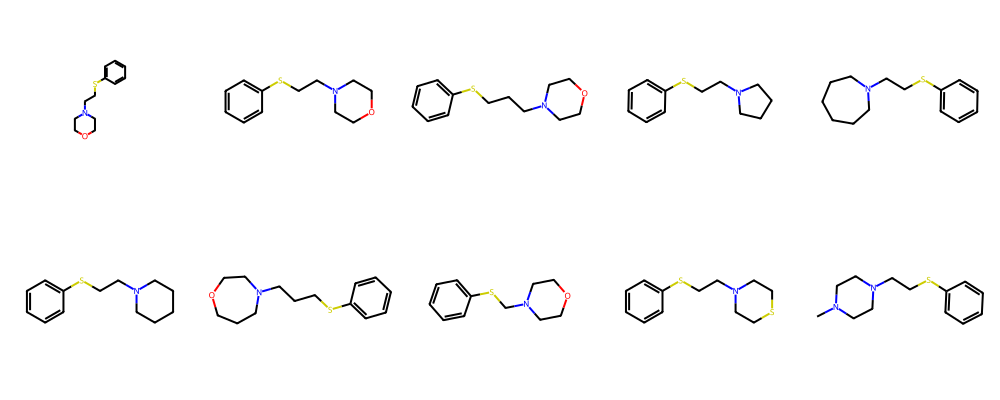

In [416]:
from random import sample
library_designer.reset_cache()
num_products = 9
products = []
for analogs_ in analogs:
    for reactants in permutations(analogs_):
        for reaction in library_designer.reactions:

            # Check if completed enumeration
            if len(products) == num_products:
                break

            # Verify reactants match
            if len(reactants) == len(reaction.reactants):

                # Perform reaction
                if output := reaction.run(reactants):
                    for product in output:
                        if smiles := unique_sanitize(product):
                            products += [Molecule(smiles, reactants=reactants)]
                else:
                    continue
                    
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([deck[0].mol, *[p.mol for p in products]], molsPerRow=5)

In [3842]:
%%time
designs = library_designer.design(deck[0], num_analogs=10, temperature=0.0)

CPU times: user 50.2 ms, sys: 0 ns, total: 50.2 ms
Wall time: 53.5 ms
